In [2]:
#####################################################################################################
# Author: Stefano Fernando Panzeri Reyes                                                            #
# Master Thesis: Data Analysis and Modelling of Induction Hardening Processes                       #
# Collaborators: USN and ENRX                                                                       #
# Year: 2023                                                                                        #     
# License: MIT License (see the LICENSE file for the full license text)                             #
# Python Version: 3.10                                                                              #             
# Description: Development of an LSTM model for error prediction.                                   #
#              - Data selection and preparation                                                     #
#              - Prediction of DC Voltage Too Low by analysing the first 10 seconds of hardening.   #
#####################################################################################################

RELEVANT IMPORTS

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

DATA SELECTION

Import and Sorting of Data from the General Client Dictionary

In [2]:
# Select Client, Job and Error to indentify 
client = 'Client2'
job = 'Job4'
errorToPredict = 2048  # DC Voltage Too Low
# Folder with Client Data filtered in pickle format
pickle_folder = os.path.join(os.getcwd(),'DATA/PickleData_Filtered')
# Import Dictionary containing individual workpieces for Client 2
dictionary = pickle.load(open(os.path.join(pickle_folder, client, 'dictionary_df_' + client + '.pickle'), 'rb'))

# Select the variables to use (according to previous analysis) - HeatingCycleTime only in use for analysis (not in model development):
variablesToUse = ["Counter", "HeatingCycleTime", "Converter_Power", "Converter_DC_Voltage", "Converter_AC_Current", "Converter_Frequency", "Y_Axis_Position", "Z_Axis_Position", "C_Axis_Position", "Inductor_WaterFlow", "Inductor_WaterTemp", "Converter_Error"]

# Group the Dataframes in different dictionaries
dictionary_df_NoErrors = {}  # Df with No Converter Errors
dictionary_df_ErrorOfInterest = {}  # Df with DC Voltage Too Low Error


for key in dictionary:  # Iterate the dictionary key by key (file by file)
    if key[25:] == job: # Only extract workpieces for the job under analysis
        df = dictionary[key]  # Import the df
        converterError = (df['Converter_Error'])   # Extract the list of all converter errors in the file
        errors = list(converterError[converterError != 0])   # Get only those different from 0
        unique_errors = list(set(errors))  # Filter to remove duplicates
        if len(unique_errors) > 0:   # Attach to dictionary if error of interest is present
            if errorToPredict in unique_errors:  
                dictionary_df_ErrorOfInterest[key] = df[variablesToUse] 
    
        else:  # Attach to dictionary if no error is present and Power was ON
            # Some dataframes do not have an error but the Power was never turned on. These should not be considered.
            converterPower = (df['Converter_Power'])  # Extract the list of all the power values in the file
            power = list(converterPower[converterPower != 0])   # Get only those different from 0
            if len(power) > 0:   
                dictionary_df_NoErrors[key] = df[variablesToUse]

Overview over Heating Cycles time

Text(0, 0.5, 'Workpieces')

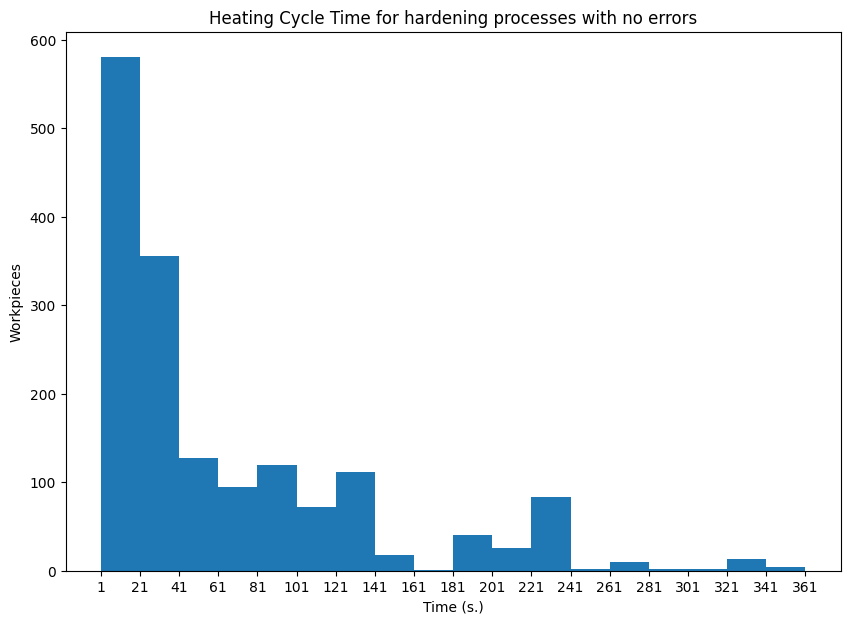

In [3]:
# HEATING CYCLE OVERVIEW FOR NON-ERROR PIECES

keysNoErrors = list(dictionary_df_NoErrors.keys())  # Extract keys for workpieces with no errors
# Create dictionary to store the max HeatingCycle Time of each workpiece (for later use)
# Calculate the interval between the first Power ON and the last Power OFF for that workpiece
heating_times_NoErrors_dictionary = {key: max(dictionary_df_NoErrors[key]['HeatingCycleTime']) for key in keysNoErrors}  
heating_times_NoErrors_values = list(heating_times_NoErrors_dictionary.values())  # Convert the dictionary values into a list

# HISTOGRAM CREATION
fig, ax = plt.subplots(figsize=(10, 7)) # Create figure with corresponding size
# Create Histogram bins every 20 s.
bins = range(int(min(heating_times_NoErrors_values)), int(max(heating_times_NoErrors_values)) + 1, 20)  # create histograms bins form min to max value, separated by 20 s.
if len(bins) < 2:  # If difference between min and max is less than 20, use min and max as bin size
    bins = [int(min(heating_times_NoErrors_values)), int(max(heating_times_NoErrors_values)) + 1]
ax.hist(heating_times_NoErrors_values, bins=bins)  # Create histogram over obtain values with the calculated bins
plt.xticks(bins)  # Use bins for X values
plt.title('Heating Cycle Time for hardening processes with no errors') # Add title
# Add labels
plt.xlabel('Time (s.)')
plt.ylabel('Workpieces')


# HEATING CYCLE OVERVIEW FOR ERROR PIECES

# Check lengths of heating cycles in file with the error of interest
keysErrors = list(dictionary_df_ErrorOfInterest.keys())  # Extract keys for workpieces with no errors
# Create a list to store the max HeatingCycle Time of each workpiece
heating_times_Errors_values = [max(dictionary_df_ErrorOfInterest[key]['HeatingCycleTime']) for key in keysErrors]

# HISTOGRAM CREATION
fig, ax = plt.subplots(figsize=(10, 7))   # Create figure with corresponding size
bins = range(int(min(heating_times_Errors_values)), int(max(heating_times_Errors_values)), 20) # create histograms bins form min to max value, separated by 20 s.
if len(bins) < 2:  # If difference between min and max is less than 20, use min and max as bin size
    bins = [int(min(heating_times_Errors_values)), int(max(heating_times_Errors_values)) + 1]
ax.hist(heating_times_Errors_values, bins=bins) # Create histogram
plt.xticks(bins)  # Use bins for X values
plt.title('Heating Cycle Time for hardening processes with errors')  # Add title
# Add labels
plt.xlabel('Time (s.)')
plt.ylabel('Workpieces')

Selection of dataframes of interest within the Non-error Ones

In [4]:
# Between the files that do not have an error, the ones with a heating cycle between 20s and 40 s will be selected
dictionary_df_NoErrors_Selected = {}  # Create filtrated dictionary
keys_NoErrors= list(heating_times_NoErrors_dictionary.keys())  # Keys of non-error files
for key in keys_NoErrors:
    if 20 <= heating_times_NoErrors_dictionary[key] <= 40:  # Length check
        dictionary_df_NoErrors_Selected[key] = dictionary_df_NoErrors[key]  # Copy to new dictionary

In [5]:
len(dictionary_df_NoErrors_Selected)

348

DATA PREPARATION

Splitting of dictionaries in relevant dictionaries for ML

In [6]:
# Split dictionaries

random.seed(21) # Set random seed for always have the same datasets

# NON-ERROR WORKPIECES
# 70% (243) of the dataframes to train, 20% to validation (70) and 10% to testing (35)
train_keys = random.sample(list(dictionary_df_NoErrors_Selected.keys()), 243)  # Extract 243 random non-error samples keys for training dictionary
train_dictionary_df_NoErrors = {key: dictionary_df_NoErrors_Selected[key] for key in train_keys}  # Create non-error training dictionary based on the above keys
remaining_dictionary_NoErrors = {key: value for key, value in dictionary_df_NoErrors_Selected.items() if key not in train_keys}  # Filter the original dictionary with the remaining entries
validation_keys = random.sample(list(remaining_dictionary_NoErrors.keys()), 70)  # Extract 70 random non-error samples keys for validation dictionary
validation_dictionary_df_NoErrors = {key: remaining_dictionary_NoErrors[key] for key in validation_keys} # Create non-error validation dictionary based on the above keys
test_dictionary_df_NoErrors = {key: value for key, value in remaining_dictionary_NoErrors.items() if key not in validation_keys} # Create non-error testing dictionary based on the remaining dictionary

# ERROR WORKPIECES
# 60% (4) of the dataframes to train, 20% to validation (2) and 20% to testing (2)
train_keys = random.sample(list(dictionary_df_ErrorOfInterest.keys()), 4)  # Extract 4 random error samples keys for training dictionary
train_dictionary_df_ErrorsOfInterest = {key: dictionary_df_ErrorOfInterest[key] for key in train_keys}  # Create error training dictionary based on the above keys
remaining_dictionary_ErrorsOfInterest = {key: value for key, value in dictionary_df_ErrorOfInterest.items() if key not in train_keys} # Filter the original dictionary with the remaining entries
validation_keys = random.sample(list(remaining_dictionary_ErrorsOfInterest.keys()), 2)  # Extract 2 random error samples keys for validation dictionary
validation_dictionary_df_ErrorsOfInterest = {key: remaining_dictionary_ErrorsOfInterest[key] for key in validation_keys} # Create error validation dictionary based on the above keys
test_dictionary_df_ErrorsOfInterest = {key: value for key, value in remaining_dictionary_ErrorsOfInterest.items() if key not in validation_keys}  # Create error testing dictionary based on the remaining dictionary

Conversion from dictionaries to ML arrays

In [7]:
# Pack into arrays for X and Y training sets and get the first 10 seconds (50 samples)
# Comments made only on TRAIN, same procedure applies for VALIDATION and TEST

# Final list to variables to use for ML development.
variablesToUse_final = ["Counter", "Converter_Power", "Converter_DC_Voltage", "Converter_AC_Current", "Converter_Frequency", "Y_Axis_Position", "Z_Axis_Position", "C_Axis_Position", "Inductor_WaterFlow", "Inductor_WaterTemp", "Converter_Error"]

# TRAIN
x_train = []
y_train = []
keys = list(train_dictionary_df_NoErrors.keys())  # Get keys for the actual dictionary
for key in keys:  # Iterate over each workpiece
    df = train_dictionary_df_NoErrors[key][variablesToUse_final]  # Filter Dataframe with relevant variables
    for index, row in df.iterrows(): # Iterate from starting to find first Power ON
        if row['Converter_Power'] > 0: # Get row when Converter is turned ON
            break
    subset_df = df.iloc[index:index+50]  # Get the first 50 samples after first power ON
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]  # Convert each column into an array
    stacked_array = np.vstack(arrays)  # Stack the arrays vertically into a single array of arrays
    
    x_train.append(stacked_array)  # Append the resulting array into the general X list
    y_train.append(False)  # The label for this data is false (No Error)

keys = list(train_dictionary_df_ErrorsOfInterest.keys())   # Get keys for the actual dictionary
for key in keys:   # Iterate over each workpiece
    df = train_dictionary_df_ErrorsOfInterest[key][variablesToUse_final]  # Filter Dataframe with relevant variables
    for index, row in df.iterrows(): # Iterate from starting for first Power ON
        if row['Converter_Power'] > 0: # Get row when Converter is turned ON
            break
    subset_df = df.iloc[index:index+50] # Get the first 50 samples after first power ON
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]   # Convert each column into an array
    stacked_array = np.vstack(arrays)  # Stack the arrays vertically into a single array of arrays
    
    for i in range(10): # Duplicate 10 times fail data (append the same 10 times)
        x_train.append(stacked_array)  # Append the resulting array into the general X list
        y_train.append(True)  # The label for this data is True (Error)

# Pack lists into array format
x_train = np.array(x_train)  
y_train = np.array(y_train)


# VALIDATION
x_validation = []
y_validation = []
keys = list(validation_dictionary_df_NoErrors.keys())
for key in keys:
    df = validation_dictionary_df_NoErrors[key][variablesToUse_final]
    for index, row in df.iterrows(): 
        if row['Converter_Power'] > 0: 
            break
    subset_df = df.iloc[index:index+50]
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]
    stacked_array = np.vstack(arrays)
    x_validation.append(stacked_array)
    y_validation.append(False)

keys = list(validation_dictionary_df_ErrorsOfInterest.keys())
for key in keys:
    df = validation_dictionary_df_ErrorsOfInterest[key][variablesToUse_final]
    for index, row in df.iterrows():
        if row['Converter_Power'] > 0:
            break
    subset_df = df.iloc[index:index+50]
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]
    stacked_array = np.vstack(arrays)
    for i in range(10): # Duplicate 10 times fail data
        x_validation.append(stacked_array)
        y_validation.append(True)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

# TEST
x_test = []
y_test = []
keys = list(test_dictionary_df_NoErrors.keys())
for key in keys:
    df = test_dictionary_df_NoErrors[key][variablesToUse_final]
    for index, row in df.iterrows():
        if row['Converter_Power'] > 0:
            break
    subset_df = df.iloc[index:index+50]
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]
    stacked_array = np.vstack(arrays)
    x_test.append(stacked_array)
    y_test.append(False)

keys = list(test_dictionary_df_ErrorsOfInterest.keys())
for key in keys:
    df = test_dictionary_df_ErrorsOfInterest[key][variablesToUse_final]
    for index, row in df.iterrows():
        if row['Converter_Power'] > 0:
            break
    subset_df = df.iloc[index:index+50]
    arrays = [row.to_numpy() for _, row in subset_df.iterrows()]
    stacked_array = np.vstack(arrays)
    for i in range(10):
        x_test.append(stacked_array)
        y_test.append(True)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [8]:
# Print shapes of the 6 created arrays
print('X Train:',x_train.shape)
print('Y Train:', y_train.shape)
print('X Validation:', x_validation.shape)
print('Y Validation:', y_validation.shape)
print('X Test:', x_test.shape)
print('Y Test:', y_test.shape)

X Train: (283, 50, 11)
Y Train: (283,)
X Validation: (90, 50, 11)
Y Validation: (90,)
X Test: (55, 50, 11)
Y Test: (55,)


Shuffling of data

In [9]:
# Shuffle data over the first dimension of the array so that the errors are not all together
# Comments made only on TRAIN, same procedure applies for VALIDATION and TEST

# TRAIN
permutation_index = np.random.permutation(len(x_train))  # Generate a common permutation index
# Apply the same permutation to both arrays. Apply also formatting.
x_train = np.array([x_train[i] for i in permutation_index]).astype(float)
y_train = np.array([y_train[i] for i in permutation_index]).astype(int)

# VALIDATION
permutation_index = np.random.permutation(len(x_validation))
x_validation = np.array([x_validation[i] for i in permutation_index]).astype(float)
y_validation = np.array([y_validation[i] for i in permutation_index]).astype(int)

# TEST
permutation_index = np.random.permutation(len(x_test))
x_test = np.array([x_test[i] for i in permutation_index]).astype(float)
y_test = np.array([y_test[i] for i in permutation_index]).astype(int)


Standardization of Data

In [10]:
def transformation(data3d):
    """
    :param data3d: Data to Standardize
    :return: Standardized Data
    """
    data2d = data3d.reshape(-1,data3d.shape[-1])  # Reshape the data into a 2D array to apply Standardization Function
    standardize = StandardScaler().fit(data2d)  # Import and adapt StandardScaler() function do data shape
    standardized_features2d = standardize.transform(data2d)  # Standardize data with StandardScaler() function
    standard_features3d = standardized_features2d.reshape(data3d.shape) # Reshape the data again into a 3D array
    return standard_features3d

# Apply Standardization to the three X arrays
x_train_transformed=transformation(x_train)
x_validation_transformed=transformation(x_validation)
x_test_transformed=transformation(x_test)

In [11]:
# Print difference between original data and Standardize Data.
print('X Train First sample of First Element (non-scaled):', x_train[0][0])
print('X Train First sample of First Element (scaled):', x_train_transformed[0][0])  # First Row of Frst Sample in array.

X Train First sample of First Element (non-scaled): [  5.       1.2112 534.7253 199.1209   7.8144 197.     257.003   86.783
  21.72    26.5      0.    ]
X Train First sample of First Element (scaled): [-1.60599688 -2.80774138  2.34258785 -3.11067008 -0.10776219 -0.09573811
 -0.77003586 -0.88128243 -0.42286084 -0.56891384  0.        ]


Saving ML Vectors

In [12]:
saving_folder = os.path.join(os.getcwd(),'LSTM_Files/LSTMVectors/Case1/TEST')
os.makedirs(saving_folder, exist_ok=True)
np.save(os.path.join(saving_folder,'x_trainCase1_transformed'),x_train_transformed)
np.save(os.path.join(saving_folder,'y_trainCase1'),y_train)
np.save(os.path.join(saving_folder,'x_validationCase1_transformed'),x_validation_transformed)
np.save(os.path.join(saving_folder,'y_validationCase1'),y_validation)
np.save(os.path.join(saving_folder,'x_testCase1_transformed'),x_test_transformed)
np.save(os.path.join(saving_folder,'y_testCase1'),y_test)

MODEL DEVELOPMENT

Definition of Relevant Functions

In [33]:
def model_setup(num_hidden_layers, num_neurons, activation_function, input_shape, output_shape):
    """
    Function to create a dynamic LSTM model, according to input parameters
    
    :param num_hidden_layers: Integer number of hidden layers (not counting input and output layer)
    :param num_neurons:  List containing number of neurons per layer
    :param activation_function: String containing activation function name for hidden layers
    :param input_shape: List containing th shape of input
    :param output_shape: List containing th shape of output
    :return: Compiled Sequential LSTM model
    """
    # Definition of model metrics
    precision = keras.metrics.Precision(name='precision')
    recall = keras.metrics.Recall(name='recall')
    
    model_LSTM = Sequential()  # Creation of empty Keras Sequential Model
    for i in range(num_hidden_layers):  # Iterate over number of hidden layers
        # Neurons in each layer are according to the number of the layer
        if i == 0: # First layer must have input shape and Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,input_shape=(input_shape[1],input_shape[2]), return_sequences=True))
        elif i == num_hidden_layers -1: # Last layer must have Return Sequences to False (no need to output all the hidden states)
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function))
        else: # Middle layers have Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,return_sequences=True))

    model_LSTM.add(Dense(units = output_shape[1], activation='sigmoid')) # Dense layer output with Sigmoid as Activation Function (binary classification)
    model_LSTM.compile(optimizer='adam', loss='mse', metrics=[precision, recall])  # Compiling using adam, Mean Square Error as loss and the two defined metrics
    return model_LSTM


def plot_training(history, type_graph, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')):
    """
    Function to Plot the Performance Metric during the training of the model
    
    :param history: Object variable containing history from model training
    :param type_graph: String with metric to plot
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure()  # create new figure
    plt.plot(history.epoch,history.history[type_graph])  # Plot the history of the selected metric for training dataset
    plt.plot(history.epoch,history.history['val_' + type_graph])  # Plot the history of the selected metric for validation dataset (in same figure)
    plt.legend(['Training Set', 'Validation Set'])  # Legend to indicate which curve correspond to each dataset
    # Add corresponding labels
    plt.ylabel(type_graph + ' score')
    plt.xlabel('epoch')
    # Add title according to the metric plotted
    name= 'Model ' + type_graph 
    plt.title(name)
    if saving:  # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 1.png'), format='png', dpi=600, transparent=True)
    plt.show()
    
def plot_prediction(y_predicted, y_test, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')):
    """ 
    Function to Plot the Predictions made by the model against the real targets
    
    :param y_predicted: List containing predicted values
    :param y_test: List containing target values (test dataset)
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure() # create new figure
    plt.plot(y_test, '-o') # Plot the real targets 
    plt.plot(y_predicted, '--*')  # Plot the predicted values with a dotted line
    plt.legend(['Target Values','Predicted Values']) # Legend to indicate which curve correspond to each variable
    # Add corresponding labels
    plt.ylabel('Presence of Error')
    plt.xlabel('Samples')
    # Add title according to the metric plotted
    name= 'Prediction on Test data'
    plt.title(name)
    if saving: # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 1.png'), format='png', dpi=600, transparent=True)
    plt.show()

Model Training

In [14]:
tf.get_logger().setLevel('ERROR')  # Avoid TensorFlow output during training if not an error

# Create dictionary with model parameters to test
model_parameters_grid = {
    'num_hidden_layers': [2,3],
    'num_neurons': {    '2layers':[ [10,3], [10,5], [10,7] ] ,
                        '3layers':[ [10,5,2], [10,7,5], [10,8,6]  ]
                    },
    'activation_functions': ['relu', 'sigmoid']
}
# Create lists with training parameters to test
epochs =  range(50,201,50)
batch_sizes = range(20,101,20)

estimator_results = {}  # Create empty dictionary containing result of every model
best_f1Score = 0  # Value to compare the F1 Score of each model and save the best one
best_recall = 0  # Value to compare the Recall Score of each model and save the best one
best_modelName_f1Score = ""   # Value to save the name of the model with the best F1 Score
best_modelName_recall = ""  # Value to save the name of the model with the best Recall Score
model_num = 0  # Model number to create Model name when this is created

# 5 nested for-loops for training to evaluate all model and training parameters combinations (from less to higher complexity)
for num_hidden_layers in model_parameters_grid['num_hidden_layers']:
    for num_neurons in model_parameters_grid['num_neurons'][str(num_hidden_layers)+'layers']:
        for activation_function in model_parameters_grid['activation_functions']:
            for epoch in epochs:
                for batch_size in batch_sizes:
                    model_name = 'model'+str(model_num) +'_'+str(epoch)+'_'+str(batch_size)  # create model name based on model config and training config
                    model = model_setup(num_hidden_layers, num_neurons, activation_function, list(x_train_transformed.shape),[y_train.shape[0], 1]) # get compiled model according to the selected configuration
                    history = model.fit(x_train_transformed, y_train,  epochs=epoch, batch_size= batch_size, verbose=0, validation_data=(x_validation_transformed, y_validation), shuffle = False)  # Train the model with training and validation data, with the corresponding training parameters
                    
                    # Get last value of precision and recall for validation
                    last_recall = history.history['val_recall'][-1]
                    last_precision = history.history['val_precision'][-1]
                    # Evaluate Recall Score with the previous best saved
                    if last_recall > best_recall:  # If better than the one saved
                        best_recall = last_recall  # Update best recall score
                        best_modelName_recall = model_name  # Update model name with best recall score
                        
                    # Calculate last value of F1 Score for validation
                    try:
                        f1_score = 2 * last_recall * last_precision / (last_recall + last_precision)
                    except ZeroDivisionError:  # Take into account the possibility that precision and recall are 0, and assign a 0 to F1 Score too
                        f1_score = 0
                    # Evaluate F1 Score with the previous best saved
                    if f1_score > best_f1Score:  # If better than the one saved
                        best_f1Score = f1_score  # Update best F1 score 
                        best_modelName_f1Score = model_name  # Update model name with best F1 score
                    
                    # Save in general dictionary the relevant parameters for the model trained
                    estimator_results[model_name] = {'model': model, 'history': history, 'f1_score': f1_score, 'epochs': epoch, 'batch_size': batch_size}
            
            # Print (for progress info) when one model configuration has been tested with all the different training parameters configurations
            print('Model ' + str(model_num) + ': DONE')  
            model_num +=1  # Increment model number for next model configuration
            
# get the dictionary containing the best F1 Score and Recall model, based on its name
best_model_F1Score = estimator_results[best_modelName_f1Score]
best_model_Recall = estimator_results[best_modelName_recall]

Model 0: DONE
Model 1: DONE
Model 2: DONE
Model 3: DONE
Model 4: DONE
Model 5: DONE
Model 6: DONE
Model 7: DONE
Model 8: DONE
Model 9: DONE
Model 10: DONE
Model 11: DONE


Saving Best Models in pickle format (model is not json serializable)

In [15]:
# saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1/TEST')
# os.makedirs(saving_path, exist_ok=True)
# with open(os.path.join(saving_path, 'best_model_F1Score_Case1.pickle'), 'wb') as f:
#     pickle.dump(best_model_F1Score, f)
# with open(os.path.join(saving_path, 'best_model_Recall_Case1.pickle'), 'wb') as f:
#     pickle.dump(best_model_Recall, f)

Import saved models to be evaluated on test data (if training does not want to be executed again)

In [24]:
importing_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')
best_model_F1Score = pickle.load(open(os.path.join(importing_path, 'best_model_F1Score_Case1.pickle'), 'rb'))
best_model_Recall = pickle.load(open(os.path.join(importing_path, 'best_model_Recall_Case1.pickle'), 'rb'))

Models' Structure

In [25]:
# Get model structure and training parameters of the best F1 Score Model
print('BEST F1 SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_F1Score.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_F1Score['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_F1Score['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_F1Score['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_F1Score['model'].get_layer(index=i).get_config()['activation'])

BEST F1 SCORE MODEL

Relevant model parameters: {'f1_score': 0.8510638137595475, 'epochs': 150, 'batch_size': 20}

Model Summary:
Model: "sequential_691"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1575 (LSTM)            (None, 50, 10)            880       
                                                                 
 lstm_1576 (LSTM)            (None, 50, 5)             320       
                                                                 
 lstm_1577 (LSTM)            (None, 2)                 64        
                                                                 
 dense_691 (Dense)           (None, 1)                 3         
                                                                 
Total params: 1267 (4.95 KB)
Trainable params: 1267 (4.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Laye

In [26]:
# Get model structure and training parameters of the best Recall Score Model
print('BEST RECALL SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_Recall.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_Recall['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_Recall['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_Recall['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_Recall['model'].get_layer(index=i).get_config()['activation'])

BEST RECALL SCORE MODEL

Relevant model parameters: {'f1_score': 0.6451612916250755, 'epochs': 150, 'batch_size': 60}

Model Summary:
Model: "sequential_573"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1329 (LSTM)            (None, 50, 10)            880       
                                                                 
 lstm_1330 (LSTM)            (None, 3)                 168       
                                                                 
 dense_573 (Dense)           (None, 1)                 4         
                                                                 
Total params: 1052 (4.11 KB)
Trainable params: 1052 (4.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Layer 1: 10 neurons; Activation Function = relu
Layer 2: 3 neurons; Activation Function = relu
Layer 3: 1 neurons; Activation Functi

MODEL PERFORMANCE AND EVALUATION

Analysis of Model Performance

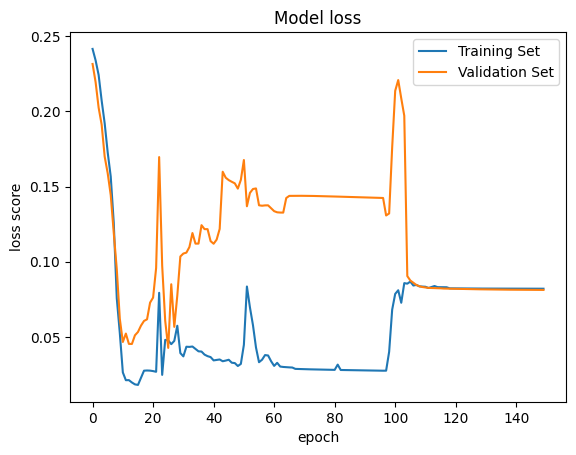

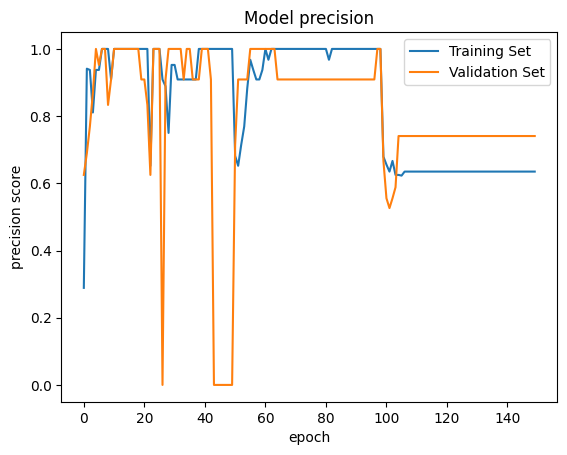

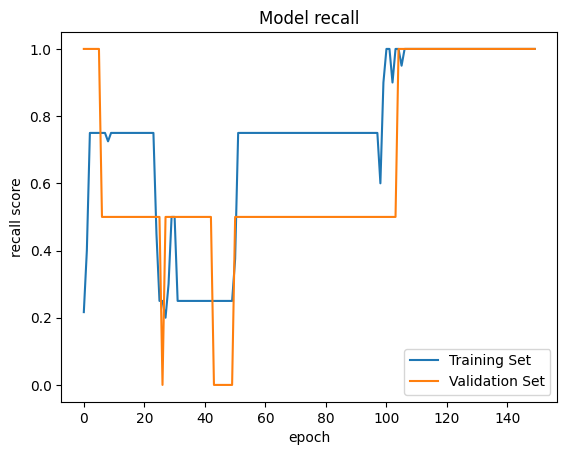

In [27]:
# Plots Performance Metrics during training and validation
history= best_model_F1Score['history']  # Get history object from dictionary
# Plot the loss and two metrics using the appropriate function
plot_training(history, type_graph='loss', saving=False)
plot_training(history, type_graph='precision', saving=False)
plot_training(history, type_graph='recall', saving=False)

Model evaluation over testing data

2/2 [==============================] - 0s 9ms/step


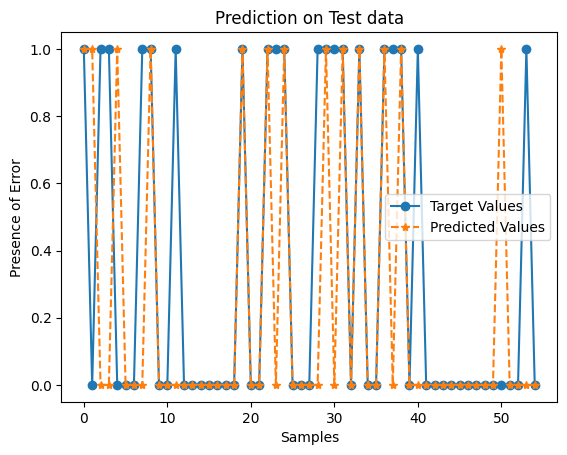

In [35]:
y_predicted_signal = best_model_F1Score['model'].predict(x_test_transformed)   # Get model predictions ove testing data
# Optimal threshold evaluation
right_predictions = 0  # variable to calculate the right predictions made by the model
for i in range(0, 100, 5): # evaluate thresholds between 0 and 1 with intervals of 0.05
    y_predicted = []  # List of binary predictions
    for j in range(len(y_predicted_signal)): # Iterate over the number of predictions made
        # Apply threshold
        if y_predicted_signal[j] > i/100:  
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    # Evaluate how many right predictions are made (TP + TN)
    # Compare results with last obtained results
    if sum(y_predicted == y_test) > right_predictions: # If better
        right_predictions = sum(y_predicted==y_test)  # Update number of right predictions
        threshold = i/100  # Update threshold value
        
# Final list is obtained by filtered the predicted signal with the optimal obtained threshold
for j in range(len(y_predicted_signal)):
        if y_predicted_signal[j] > threshold:
            y_predicted [j] = 1
        else:
            y_predicted[j] = 0
            
# Plot the predictions and two metrics using the appropriate function
plot_prediction(y_predicted, y_test, saving=False)

In [30]:
# Print the obtained threshold and the number of right predictions made
print('Threshold:', threshold)
print('Correct Predictions:',sum(y_predicted == y_test))

Threshold: 0.45
Correct Predictions: 42


In [31]:
# Evaluate final performance over test data
f1_score_test = keras.metrics.F1Score()  # Import F1 Score metric from Keras
precision_test = keras.metrics.Precision()  # Import Precision Score metric from Keras
recall_test = keras.metrics.Recall()  # Import Recall Score metric from Keras
# Update the metrics giving as input the target and predicted arrays in a 2D shape
f1_score_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
precision_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
recall_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
# Print Results
print('Testing F1 Score: ', f1_score_test.result().numpy()[0])
print('Testing Precision: ', precision_test.result().numpy())
print('Testing Recall: ', recall_test.result().numpy())

Testing F1 Score:  0.60606056
Testing Precision:  0.7692308
Testing Recall:  0.5
